OSE scentific computation final report  WS 2020/2021 Bonn University
Title
author: Po-Tse Cheng

In [1]:
import numpy as np 
import pandas as pd
import math
import time
import seaborn as sns
import matplotlib.pyplot as plt

from tools.auxiliary import*
from tools.GSSA_1_agent import*

What you can expect in this notebook:

- All of the matlab codes from the original authors have been translated into python, including Appendix.
- Besides of the representitive agent model, a multicountry model purposed by the paper is also implemented in python.

What is the caveat:

- The time in general will not match, as python in general is slower than matlab.
- Accuracy will also differs, but in general will not affect our conclusion.
- Two proximation methods included in GSSA, namely LAD-DP and RLAD-DP is not implemented



To do: draw smaller samples, because 10000 is taking way too long

we will follow 3000 instead 10000

10000 is for showcase results only

This notebook contains the python implementation of the General Stochastic Simulation Algorithm (GSSA), developed by Kenneth L. Judde et. al (2011). 

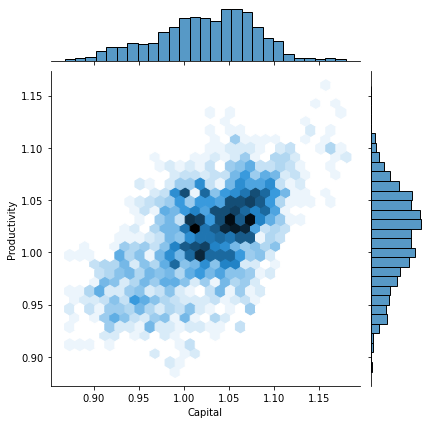

In [2]:
Figure1()

In [3]:
showcase_result = GSSA_ShowcaseResult()

In [4]:
showcase_result

,Maximum Error,Mean Error,Time,Error Time,Polynomial Degree,Total Time,Rounded Total Time,Original Mean Error,Original Max Error
0,-3.366134,-4.358702,30.729357,0.733039,1,31.462396,31.46,4.378225e-05,4.303938e-04
1,-4.883611,-6.118154,49.549238,0.767948,2,50.317186,50.32,7.618090e-07,1.307343e-05
2,-5.951989,-7.481158,91.358068,0.881599,3,92.239668,92.24,3.302497e-08,1.116891e-06
3,-7.021109,-8.716908,93.616499,0.992344,4,94.608844,94.61,1.919073e-09,9.525560e-08
4,-7.178648,-8.893002,136.366108,1.117072,5,137.483180,137.48,1.279377e-09,6.627529e-08


<AxesSubplot:label='4a59d8ca-0f20-4f21-b851-b7c2b337f294', xlabel='Rounded Total Time', ylabel='Mean Error'>

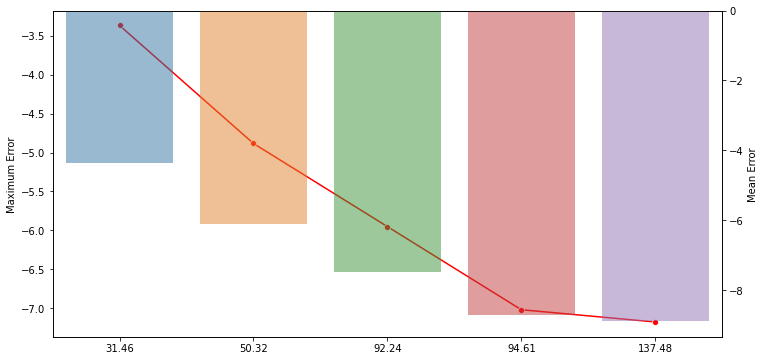

In [5]:
#plot with regards to time, maxi for visualisation
# will be added to auxiliary
# add title and so on
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = showcase_result["Maximum Error"], marker='o', ax=ax1, color='r')
ax2 = ax1.twinx()

sns.barplot(data = showcase_result, x="Rounded Total Time", y="Mean Error", alpha=0.5, ax=ax2)

In [6]:
# IM = one node MC only
# RM = RLS-TSVD
# Smaller regulation k = 7
# Hermite
max_6_2, mean_6_2, error_time_6_2, Time_6_2, stage1_time_6_2 = GSSA_1_agent(D_max=5, IM=0, RM=6 ,normalize=1, penalty=7, PF=1)

In [7]:
# IM = one node MC only
# RM = RLS-TSVD
# large regulation k = 3
# Hermite
max_6_3, mean_6_3, error_time_6_3, Time_6_3, stage1_time_6_3 = GSSA_1_agent(D_max=5, IM=0, RM=6 ,normalize=1, penalty=3, PF=1)

In [8]:
# IM = one node MC only
# RM = RLS-TSVD
# Smaller regulation k = 7
max_6, mean_6, error_time_6, Time_6, stage1_time_6 = GSSA_1_agent(D_max=5, IM=0, RM=6 ,normalize=1, penalty=7, PF=0)

In [9]:
# IM = one node MC only
# RM = RLS-TSVD
# Larger regulation k = 3
max_6_0, mean_6_0, error_time_6_0, Time_6_0, stage1_time_6_0 = GSSA_1_agent(D_max=5, IM=0, RM=6 ,normalize=1, penalty=3, PF=0)

In [10]:
# IM = one node MC only
# RM = LS-SVD
# without normalisation
max_2_0, mean_2_0, error_time_2_0, Time_2_0, stage1_time_2_0 = GSSA_1_agent(D_max=4, IM=0, RM=2 ,normalize=0, penalty=3, PF=0)

In [11]:
# IM = one node MC only
# RM = LS-SVD
# with normalisation
max_2_1, mean_2_1, error_time_2_1, Time_2_1, stage1_time_2_1 = GSSA_1_agent(D_max=5, IM=0, RM=2 ,normalize=1, penalty=3, PF=0)

In [12]:
# IM = one node MC only
# RM = LS-SVD
# without normalisation with hermite
max_2_2, mean_2_2, error_time_2_2, Time_2_2, stage1_time_2_2 = GSSA_1_agent(D_max=5, IM=0, RM=2 ,normalize=0, penalty=3, PF=1)

In [13]:
mean_2_0.append(None)
Time_2_0.append(None)
max_2_0.append(None)

In [14]:
df = pd.DataFrame({'LSV_un':mean_2_0,
'LSV_n':mean_2_1,
'LSV_h':mean_2_2,
'RLSV_small':mean_6_0,
'RLSV_large':mean_6,
"RLSV_h_small":mean_6_2,
"RLSV_h_large":mean_6_3
})